In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ResNet 
## 기본블럭 만들기
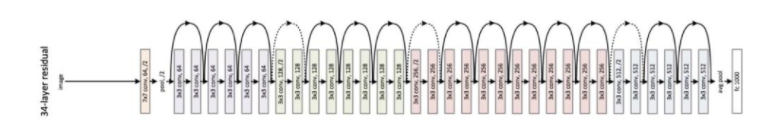
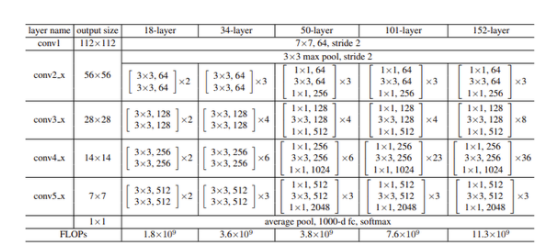
* ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태이다. 
* ResNet-34 블럭 내부 구성은 3x3 kernel인 Convolution layer로만 구성되어있다.
* ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지고있다.

입력인자
* input_layer : 블럭 앞에 존재하는 입력층을 전달
* num_cnn : 블럭 안에 conv layer 수
* block_num : channel 수와 몇번째 블럭인지 나타냄
* is_50 : True 면 ResNet-50 / False 면 ResNet-34
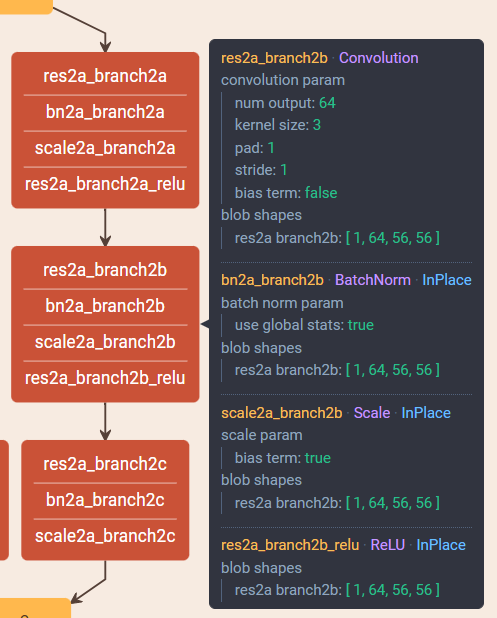

In [3]:
# Conv - BN - Activation

def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = input_layer
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(x)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation: # 유닛의 마지막 블럭은 activation
        x = keras.layers.Activation(activation)(x)
    
    return x

In [4]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0: # 유닛의 첫번째 레이어 
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [5]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    assert len(num_cnn_list) == len(channel_list) 
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)  
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

# ResNet-34

In [6]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

# ResNet-50

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

# PlainNet 기본블럭 만들기

In [8]:
# resnet block에서 shortcut을 제외한다.
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [9]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

# PlainNet-34

In [10]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

# PlainNet-50

In [11]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

# 모델 성능 평가
## 1. 데이터셋 다운 및 확인
dataset : cats_vs_dogs

In [12]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [13]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [14]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [15]:
# 카테고리 개수 확인
ds_info.features["label"].num_classes

2

In [16]:
# 카테고리 이름 확인
ds_info.features["label"].names

['cat', 'dog']

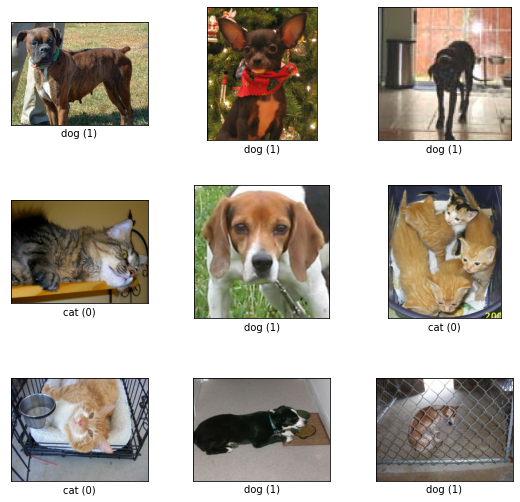

In [17]:
# train image sample 확인
fig=tfds.show_examples(ds_train, ds_info)

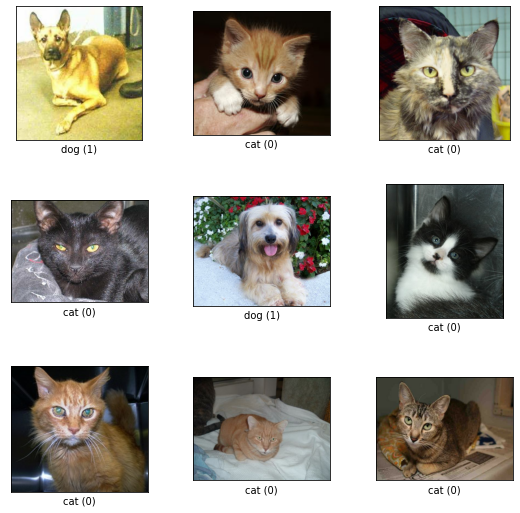

In [18]:
# test image sample 확인
fig=tfds.show_examples(ds_test,ds_info)

## 2. 데이터셋 안에 있는 이미지 정규화하기

In [19]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [20]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 3. 훈련시키기

In [21]:
BATCH_SIZE = 16
EPOCH = 10

In [22]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [23]:
model_resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

model_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_resnet_50 = model_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
 193/1163 [===>..........................] - ETA: 1:12 - loss: 6.0464 - accuracy: 0.5661

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 1:07 - loss: 5.8880 - accuracy: 0.5736

 279/1163 [======>.......................] - ETA: 1:06 - loss: 5.8370 - accuracy: 0.5791

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 55s - loss: 5.5180 - accuracy: 0.5897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 24s - loss: 4.6868 - accuracy: 0.6176

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 22s - loss: 4.6482 - accuracy: 0.6186

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1163 [=====================>........] - ETA: 20s - loss: 4.6134 - accuracy: 0.6181

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 940/1163 [=======================>......] - ETA: 16s - loss: 4.5224 - accuracy: 0.6215

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 15s - loss: 4.5032 - accuracy: 0.6216

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.1836 - accuracy: 0.6259

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 112s 86ms/step - loss: 4.1836 - accuracy: 0.6259 - val_loss: 2.5405 - val_accuracy: 0.6596
Epoch 2/10
 196/1163 [====>.........................] - ETA: 1:12 - loss: 2.3666 - accuracy: 0.6687

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1163 [=====>........................] - ETA: 1:08 - loss: 2.3216 - accuracy: 0.6718

 278/1163 [======>.......................] - ETA: 1:06 - loss: 2.3038 - accuracy: 0.6740

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 55s - loss: 2.2055 - accuracy: 0.6777

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 24s - loss: 1.9828 - accuracy: 0.6852

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 22s - loss: 1.9746 - accuracy: 0.6850

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 20s - loss: 1.9632 - accuracy: 0.6861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 16s - loss: 1.9402 - accuracy: 0.6863

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 15s - loss: 1.9348 - accuracy: 0.6868

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.8513 - accuracy: 0.6897

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 83ms/step - loss: 1.8513 - accuracy: 0.6897 - val_loss: 1.6820 - val_accuracy: 0.5787
Epoch 3/10
 199/1163 [====>.........................] - ETA: 1:12 - loss: 1.4015 - accuracy: 0.6815

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 1:07 - loss: 1.3903 - accuracy: 0.6807

 278/1163 [======>.......................] - ETA: 1:06 - loss: 1.3879 - accuracy: 0.6794

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 54s - loss: 1.3559 - accuracy: 0.6866

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 23s - loss: 1.3076 - accuracy: 0.6812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 22s - loss: 1.3042 - accuracy: 0.6811

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 20s - loss: 1.3011 - accuracy: 0.6806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 16s - loss: 1.2956 - accuracy: 0.6799

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 15s - loss: 1.2929 - accuracy: 0.6806

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.2555 - accuracy: 0.6879

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 82ms/step - loss: 1.2555 - accuracy: 0.6879 - val_loss: 1.0589 - val_accuracy: 0.6984
Epoch 4/10
 196/1163 [====>.........................] - ETA: 1:12 - loss: 1.0080 - accuracy: 0.7353

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 1:07 - loss: 1.0102 - accuracy: 0.7288

 282/1163 [======>.......................] - ETA: 1:05 - loss: 1.0105 - accuracy: 0.7258

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 54s - loss: 0.9984 - accuracy: 0.7261

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 23s - loss: 0.9463 - accuracy: 0.7425

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 22s - loss: 0.9448 - accuracy: 0.7421

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 20s - loss: 0.9430 - accuracy: 0.7415

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 16s - loss: 0.9374 - accuracy: 0.7438

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 15s - loss: 0.9362 - accuracy: 0.7446

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.7463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 82ms/step - loss: 0.9206 - accuracy: 0.7463 - val_loss: 0.9924 - val_accuracy: 0.6140
Epoch 5/10
 198/1163 [====>.........................] - ETA: 1:12 - loss: 0.8118 - accuracy: 0.7677

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:07 - loss: 0.7967 - accuracy: 0.7780

 286/1163 [======>.......................] - ETA: 1:05 - loss: 0.7968 - accuracy: 0.7771

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 54s - loss: 0.7973 - accuracy: 0.7716

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 23s - loss: 0.7778 - accuracy: 0.7752

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 21s - loss: 0.7745 - accuracy: 0.7763

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 20s - loss: 0.7746 - accuracy: 0.7762

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 16s - loss: 0.7779 - accuracy: 0.7749

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 15s - loss: 0.7785 - accuracy: 0.7741

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.7737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 82ms/step - loss: 0.7745 - accuracy: 0.7737 - val_loss: 3.9751 - val_accuracy: 0.6227
Epoch 6/10
 197/1163 [====>.........................] - ETA: 1:11 - loss: 0.7224 - accuracy: 0.7916

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 1:07 - loss: 0.7186 - accuracy: 0.7913

 285/1163 [======>.......................] - ETA: 1:05 - loss: 0.7241 - accuracy: 0.7895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 54s - loss: 0.7284 - accuracy: 0.7858

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 23s - loss: 0.7237 - accuracy: 0.7833

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 21s - loss: 0.7241 - accuracy: 0.7837

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 20s - loss: 0.7223 - accuracy: 0.7852

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 16s - loss: 0.7220 - accuracy: 0.7850

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 15s - loss: 0.7220 - accuracy: 0.7850

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.7901

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 83ms/step - loss: 0.7114 - accuracy: 0.7901 - val_loss: 0.9927 - val_accuracy: 0.6579
Epoch 7/10
 199/1163 [====>.........................] - ETA: 1:11 - loss: 0.6404 - accuracy: 0.8142

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:06 - loss: 0.6362 - accuracy: 0.8204

 284/1163 [======>.......................] - ETA: 1:05 - loss: 0.6408 - accuracy: 0.8168

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 54s - loss: 0.6405 - accuracy: 0.8139

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 23s - loss: 0.6478 - accuracy: 0.8118

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 21s - loss: 0.6467 - accuracy: 0.8120

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 19s - loss: 0.6449 - accuracy: 0.8128

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 15s - loss: 0.6424 - accuracy: 0.8128

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 15s - loss: 0.6417 - accuracy: 0.8132

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.8101

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 82ms/step - loss: 0.6538 - accuracy: 0.8101 - val_loss: 0.9044 - val_accuracy: 0.7759
Epoch 8/10
 203/1163 [====>.........................] - ETA: 1:11 - loss: 0.6328 - accuracy: 0.8220

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 1:06 - loss: 0.6226 - accuracy: 0.8259

 284/1163 [======>.......................] - ETA: 1:05 - loss: 0.6217 - accuracy: 0.8249

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 54s - loss: 0.6149 - accuracy: 0.8256

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 23s - loss: 0.6010 - accuracy: 0.8300

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 21s - loss: 0.6004 - accuracy: 0.8299

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 19s - loss: 0.6000 - accuracy: 0.8299

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 15s - loss: 0.5993 - accuracy: 0.8304

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 14s - loss: 0.5994 - accuracy: 0.8304

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.8310

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 82ms/step - loss: 0.5939 - accuracy: 0.8310 - val_loss: 55.0022 - val_accuracy: 0.4994
Epoch 9/10
 202/1163 [====>.........................] - ETA: 1:11 - loss: 0.5711 - accuracy: 0.8397

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 267/1163 [=====>........................] - ETA: 1:06 - loss: 0.5587 - accuracy: 0.8432

 288/1163 [======>.......................] - ETA: 1:05 - loss: 0.5557 - accuracy: 0.8441

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 54s - loss: 0.5658 - accuracy: 0.8395

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 23s - loss: 0.5537 - accuracy: 0.8438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 21s - loss: 0.5521 - accuracy: 0.8445

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 20s - loss: 0.5528 - accuracy: 0.8442

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 16s - loss: 0.5501 - accuracy: 0.8461

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 15s - loss: 0.5502 - accuracy: 0.8463

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.8490

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 96s 82ms/step - loss: 0.5423 - accuracy: 0.8490 - val_loss: 0.8345 - val_accuracy: 0.7177
Epoch 10/10
 202/1163 [====>.........................] - ETA: 1:11 - loss: 0.5312 - accuracy: 0.8564

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 267/1163 [=====>........................] - ETA: 1:06 - loss: 0.5223 - accuracy: 0.8581

 290/1163 [======>.......................] - ETA: 1:04 - loss: 0.5208 - accuracy: 0.8584

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 439/1163 [==========>...................] - ETA: 53s - loss: 0.5072 - accuracy: 0.8625

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 23s - loss: 0.5133 - accuracy: 0.8592

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 875/1163 [=====================>........] - ETA: 21s - loss: 0.5109 - accuracy: 0.8607

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 19s - loss: 0.5105 - accuracy: 0.8608

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 15s - loss: 0.5075 - accuracy: 0.8616

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 14s - loss: 0.5070 - accuracy: 0.8617

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.8628

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 82ms/step - loss: 0.5026 - accuracy: 0.8628 - val_loss: 0.6024 - val_accuracy: 0.7948


In [24]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3),                                
                               num_classes=1, 
                               is_50=False, 
                               activation='sigmoid', 
                               name='ResNet_34')

model_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_resnet_34 = model_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
 194/1163 [====>.........................] - ETA: 1:40 - loss: 2.4532 - accuracy: 0.5873

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1163 [=====>........................] - ETA: 1:34 - loss: 2.4026 - accuracy: 0.5773

 278/1163 [======>.......................] - ETA: 1:31 - loss: 2.3823 - accuracy: 0.5758

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:16 - loss: 2.2587 - accuracy: 0.5861

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1163 [====================>.........] - ETA: 33s - loss: 1.9843 - accuracy: 0.5914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 30s - loss: 1.9674 - accuracy: 0.5927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 28s - loss: 1.9525 - accuracy: 0.5921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 22s - loss: 1.9199 - accuracy: 0.5943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 21s - loss: 1.9130 - accuracy: 0.5948

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.8025 - accuracy: 0.5974

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 140s 114ms/step - loss: 1.8025 - accuracy: 0.5974 - val_loss: 1.6490 - val_accuracy: 0.5304
Epoch 2/10
 196/1163 [====>.........................] - ETA: 1:39 - loss: 1.1569 - accuracy: 0.6368

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1163 [=====>........................] - ETA: 1:33 - loss: 1.1399 - accuracy: 0.6382

 278/1163 [======>.......................] - ETA: 1:31 - loss: 1.1351 - accuracy: 0.6383

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 1:16 - loss: 1.0952 - accuracy: 0.6474

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 32s - loss: 1.0016 - accuracy: 0.6689

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 30s - loss: 0.9984 - accuracy: 0.6696

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 27s - loss: 0.9957 - accuracy: 0.6683

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 22s - loss: 0.9888 - accuracy: 0.6684

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 21s - loss: 0.9862 - accuracy: 0.6693

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.9560 - accuracy: 0.6741

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 132s 113ms/step - loss: 0.9560 - accuracy: 0.6741 - val_loss: 0.8379 - val_accuracy: 0.6493
Epoch 3/10
 198/1163 [====>.........................] - ETA: 1:39 - loss: 0.7563 - accuracy: 0.7298

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:33 - loss: 0.7550 - accuracy: 0.7302

 280/1163 [======>.......................] - ETA: 1:31 - loss: 0.7544 - accuracy: 0.7295

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 1:16 - loss: 0.7461 - accuracy: 0.7276

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 32s - loss: 0.7228 - accuracy: 0.7325

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 30s - loss: 0.7213 - accuracy: 0.7338

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 28s - loss: 0.7223 - accuracy: 0.7331

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 22s - loss: 0.7180 - accuracy: 0.7350

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 21s - loss: 0.7171 - accuracy: 0.7354

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.7365

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 132s 113ms/step - loss: 0.7088 - accuracy: 0.7365 - val_loss: 1.5335 - val_accuracy: 0.5071
Epoch 4/10
 200/1163 [====>.........................] - ETA: 1:39 - loss: 0.6370 - accuracy: 0.7674

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:33 - loss: 0.6340 - accuracy: 0.7671

 285/1163 [======>.......................] - ETA: 1:30 - loss: 0.6349 - accuracy: 0.7666

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:15 - loss: 0.6357 - accuracy: 0.7639

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 33s - loss: 0.6264 - accuracy: 0.7670

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 30s - loss: 0.6244 - accuracy: 0.7680

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 28s - loss: 0.6243 - accuracy: 0.7684

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 22s - loss: 0.6238 - accuracy: 0.7691

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 21s - loss: 0.6242 - accuracy: 0.7691

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.7674

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 132s 113ms/step - loss: 0.6247 - accuracy: 0.7674 - val_loss: 1.1461 - val_accuracy: 0.6156
Epoch 5/10
 198/1163 [====>.........................] - ETA: 1:39 - loss: 0.5885 - accuracy: 0.7882

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:32 - loss: 0.5858 - accuracy: 0.7895

 281/1163 [======>.......................] - ETA: 1:31 - loss: 0.5906 - accuracy: 0.7898

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 1:15 - loss: 0.5894 - accuracy: 0.7927

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 33s - loss: 0.5848 - accuracy: 0.7942

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 30s - loss: 0.5842 - accuracy: 0.7949

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 27s - loss: 0.5831 - accuracy: 0.7957

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 22s - loss: 0.5832 - accuracy: 0.7973

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 20s - loss: 0.5839 - accuracy: 0.7966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.7975

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 132s 114ms/step - loss: 0.5845 - accuracy: 0.7975 - val_loss: 1.0056 - val_accuracy: 0.5101
Epoch 6/10
 200/1163 [====>.........................] - ETA: 1:39 - loss: 0.5406 - accuracy: 0.8141

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 259/1163 [=====>........................] - ETA: 1:33 - loss: 0.5405 - accuracy: 0.8156

 282/1163 [======>.......................] - ETA: 1:31 - loss: 0.5490 - accuracy: 0.8103

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:15 - loss: 0.5421 - accuracy: 0.8126

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 32s - loss: 0.5403 - accuracy: 0.8211

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 30s - loss: 0.5409 - accuracy: 0.8209

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 27s - loss: 0.5402 - accuracy: 0.8214

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 22s - loss: 0.5390 - accuracy: 0.8211

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 20s - loss: 0.5388 - accuracy: 0.8215

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.8221

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 132s 113ms/step - loss: 0.5389 - accuracy: 0.8221 - val_loss: 0.8931 - val_accuracy: 0.5940
Epoch 7/10
 198/1163 [====>.........................] - ETA: 1:39 - loss: 0.5113 - accuracy: 0.8346

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:32 - loss: 0.5104 - accuracy: 0.8344

 285/1163 [======>.......................] - ETA: 1:30 - loss: 0.5068 - accuracy: 0.8362

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 1:15 - loss: 0.5005 - accuracy: 0.8408

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 32s - loss: 0.5069 - accuracy: 0.8413

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 30s - loss: 0.5060 - accuracy: 0.8416

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 27s - loss: 0.5070 - accuracy: 0.8409

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 22s - loss: 0.5063 - accuracy: 0.8418

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 21s - loss: 0.5065 - accuracy: 0.8415

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.8404

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 132s 113ms/step - loss: 0.5076 - accuracy: 0.8404 - val_loss: 0.5522 - val_accuracy: 0.8296
Epoch 8/10
 202/1163 [====>.........................] - ETA: 1:39 - loss: 0.4907 - accuracy: 0.8434

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:33 - loss: 0.4800 - accuracy: 0.8503

 284/1163 [======>.......................] - ETA: 1:30 - loss: 0.4803 - accuracy: 0.8508

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:15 - loss: 0.4686 - accuracy: 0.8577

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 32s - loss: 0.4662 - accuracy: 0.8603

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 30s - loss: 0.4648 - accuracy: 0.8610

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 27s - loss: 0.4670 - accuracy: 0.8602

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 21s - loss: 0.4643 - accuracy: 0.8617

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 20s - loss: 0.4648 - accuracy: 0.8615

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8643

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 131s 113ms/step - loss: 0.4583 - accuracy: 0.8643 - val_loss: 0.5135 - val_accuracy: 0.8241
Epoch 9/10
 201/1163 [====>.........................] - ETA: 1:38 - loss: 0.4608 - accuracy: 0.8582

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:32 - loss: 0.4486 - accuracy: 0.8614

 287/1163 [======>.......................] - ETA: 1:30 - loss: 0.4486 - accuracy: 0.8622

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 1:14 - loss: 0.4431 - accuracy: 0.8671

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 32s - loss: 0.4340 - accuracy: 0.8754

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 29s - loss: 0.4317 - accuracy: 0.8763

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 898/1163 [======================>.......] - ETA: 27s - loss: 0.4308 - accuracy: 0.8768

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 21s - loss: 0.4338 - accuracy: 0.8757

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 20s - loss: 0.4335 - accuracy: 0.8760

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8775

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 131s 113ms/step - loss: 0.4291 - accuracy: 0.8775 - val_loss: 0.6523 - val_accuracy: 0.7349
Epoch 10/10
 201/1163 [====>.........................] - ETA: 1:38 - loss: 0.4046 - accuracy: 0.8899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:32 - loss: 0.4313 - accuracy: 0.8830

 286/1163 [======>.......................] - ETA: 1:30 - loss: 0.4291 - accuracy: 0.8822

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 437/1163 [==========>...................] - ETA: 1:14 - loss: 0.4213 - accuracy: 0.8829

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 32s - loss: 0.4194 - accuracy: 0.8814

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 29s - loss: 0.4202 - accuracy: 0.8814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 899/1163 [======================>.......] - ETA: 27s - loss: 0.4194 - accuracy: 0.8818

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 21s - loss: 0.4192 - accuracy: 0.8827

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1163 [=======================>......] - ETA: 20s - loss: 0.4193 - accuracy: 0.8825

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.8848

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 131s 112ms/step - loss: 0.4184 - accuracy: 0.8848 - val_loss: 0.7492 - val_accuracy: 0.6594


In [25]:
model_plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

model_plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_plain_34 = model_plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 195/1163 [====>.........................] - ETA: 1:35 - loss: 2.1358 - accuracy: 0.5131

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1163 [=====>........................] - ETA: 1:30 - loss: 2.0685 - accuracy: 0.5221

 278/1163 [======>.......................] - ETA: 1:27 - loss: 2.0453 - accuracy: 0.5243

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:12 - loss: 1.9086 - accuracy: 0.5303

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 31s - loss: 1.6504 - accuracy: 0.5304

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 29s - loss: 1.6408 - accuracy: 0.5303

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1163 [=====================>........] - ETA: 27s - loss: 1.6303 - accuracy: 0.5307

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1163 [=======================>......] - ETA: 21s - loss: 1.6067 - accuracy: 0.5321

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1163 [=======================>......] - ETA: 20s - loss: 1.6020 - accuracy: 0.5315

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.5245 - accuracy: 0.5273

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 133s 109ms/step - loss: 1.5245 - accuracy: 0.5273 - val_loss: 1.2290 - val_accuracy: 0.5455
Epoch 2/10
 197/1163 [====>.........................] - ETA: 1:35 - loss: 1.1145 - accuracy: 0.5209

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 1:29 - loss: 1.1067 - accuracy: 0.5260

 277/1163 [======>.......................] - ETA: 1:27 - loss: 1.1064 - accuracy: 0.5250

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 1:12 - loss: 1.0863 - accuracy: 0.5300

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 31s - loss: 1.0358 - accuracy: 0.5281

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 29s - loss: 1.0347 - accuracy: 0.5269

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 27s - loss: 1.0325 - accuracy: 0.5262

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 21s - loss: 1.0271 - accuracy: 0.5262

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 956/1163 [=======================>......] - ETA: 20s - loss: 1.0260 - accuracy: 0.5254

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.0098 - accuracy: 0.5226

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 1.0098 - accuracy: 0.5226 - val_loss: 0.9324 - val_accuracy: 0.5063
Epoch 3/10
 197/1163 [====>.........................] - ETA: 1:35 - loss: 0.9216 - accuracy: 0.5133

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:28 - loss: 0.9221 - accuracy: 0.5109

 278/1163 [======>.......................] - ETA: 1:27 - loss: 0.9195 - accuracy: 0.5157

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 1:12 - loss: 0.9089 - accuracy: 0.5256

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 843/1163 [====================>.........] - ETA: 31s - loss: 0.9052 - accuracy: 0.5201

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 864/1163 [=====================>........] - ETA: 29s - loss: 0.9063 - accuracy: 0.5214

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 26s - loss: 0.9072 - accuracy: 0.5202

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 21s - loss: 0.9067 - accuracy: 0.5189

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 20s - loss: 0.9065 - accuracy: 0.5186

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.9042 - accuracy: 0.5175

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 0.9042 - accuracy: 0.5175 - val_loss: 0.8608 - val_accuracy: 0.5121
Epoch 4/10
 197/1163 [====>.........................] - ETA: 1:35 - loss: 0.8890 - accuracy: 0.5076

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 1:29 - loss: 0.8799 - accuracy: 0.5062

 285/1163 [======>.......................] - ETA: 1:26 - loss: 0.8767 - accuracy: 0.5088

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:12 - loss: 0.8682 - accuracy: 0.5019

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 841/1163 [====================>.........] - ETA: 31s - loss: 0.8427 - accuracy: 0.5097

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 28s - loss: 0.8424 - accuracy: 0.5092

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 26s - loss: 0.8421 - accuracy: 0.5087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 21s - loss: 0.8406 - accuracy: 0.5087

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 20s - loss: 0.8400 - accuracy: 0.5093

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8361 - accuracy: 0.5119

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 0.8361 - accuracy: 0.5119 - val_loss: 11.3917 - val_accuracy: 0.4899
Epoch 5/10
 200/1163 [====>.........................] - ETA: 1:35 - loss: 0.8297 - accuracy: 0.5097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 1:28 - loss: 0.8224 - accuracy: 0.5101

 280/1163 [======>.......................] - ETA: 1:27 - loss: 0.8269 - accuracy: 0.5094

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:12 - loss: 0.8356 - accuracy: 0.5131

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 31s - loss: 0.8233 - accuracy: 0.5115

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 29s - loss: 0.8223 - accuracy: 0.5118

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 26s - loss: 0.8209 - accuracy: 0.5114

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 21s - loss: 0.8192 - accuracy: 0.5105

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 20s - loss: 0.8187 - accuracy: 0.5107

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8146 - accuracy: 0.5123

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 0.8146 - accuracy: 0.5123 - val_loss: 0.7720 - val_accuracy: 0.5317
Epoch 6/10
 202/1163 [====>.........................] - ETA: 1:34 - loss: 0.7815 - accuracy: 0.5189

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:28 - loss: 0.7871 - accuracy: 0.5266

 285/1163 [======>.......................] - ETA: 1:26 - loss: 0.7884 - accuracy: 0.5206

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 1:11 - loss: 0.7855 - accuracy: 0.5121

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 31s - loss: 0.7717 - accuracy: 0.5139

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 28s - loss: 0.7717 - accuracy: 0.5148

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 893/1163 [======================>.......] - ETA: 26s - loss: 0.7731 - accuracy: 0.5135

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 947/1163 [=======================>......] - ETA: 21s - loss: 0.7733 - accuracy: 0.5123

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 20s - loss: 0.7729 - accuracy: 0.5132

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.5104

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 0.7741 - accuracy: 0.5104 - val_loss: 0.7725 - val_accuracy: 0.4881
Epoch 7/10
 199/1163 [====>.........................] - ETA: 1:35 - loss: 0.7892 - accuracy: 0.5057

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:28 - loss: 0.7816 - accuracy: 0.5083

 287/1163 [======>.......................] - ETA: 1:26 - loss: 0.7798 - accuracy: 0.5098

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:11 - loss: 0.7699 - accuracy: 0.5162

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 31s - loss: 0.7654 - accuracy: 0.5182

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 28s - loss: 0.7671 - accuracy: 0.5170

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 26s - loss: 0.7679 - accuracy: 0.5160

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 20s - loss: 0.7685 - accuracy: 0.5146

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 19s - loss: 0.7691 - accuracy: 0.5146

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7727 - accuracy: 0.5133

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 0.7727 - accuracy: 0.5133 - val_loss: 0.9109 - val_accuracy: 0.5612
Epoch 8/10
 205/1163 [====>.........................] - ETA: 1:34 - loss: 0.7382 - accuracy: 0.5122

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:28 - loss: 0.7369 - accuracy: 0.5109

 288/1163 [======>.......................] - ETA: 1:26 - loss: 0.7379 - accuracy: 0.5135

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:11 - loss: 0.7559 - accuracy: 0.5065

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 31s - loss: 0.7627 - accuracy: 0.5095

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 873/1163 [=====================>........] - ETA: 28s - loss: 0.7624 - accuracy: 0.5080

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 26s - loss: 0.7617 - accuracy: 0.5083

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 21s - loss: 0.7612 - accuracy: 0.5080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 19s - loss: 0.7622 - accuracy: 0.5076

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7698 - accuracy: 0.5087

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 0.7698 - accuracy: 0.5087 - val_loss: 0.7896 - val_accuracy: 0.4886
Epoch 9/10
 200/1163 [====>.........................] - ETA: 1:34 - loss: 0.7500 - accuracy: 0.5082

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 267/1163 [=====>........................] - ETA: 1:28 - loss: 0.7458 - accuracy: 0.5059

 286/1163 [======>.......................] - ETA: 1:26 - loss: 0.7446 - accuracy: 0.5079

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:11 - loss: 0.7352 - accuracy: 0.5188

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1163 [====================>.........] - ETA: 30s - loss: 0.7260 - accuracy: 0.5234

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 28s - loss: 0.7258 - accuracy: 0.5229

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 26s - loss: 0.7253 - accuracy: 0.5228

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 20s - loss: 0.7244 - accuracy: 0.5250

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 19s - loss: 0.7242 - accuracy: 0.5247

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.5265

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 0.7290 - accuracy: 0.5265 - val_loss: 0.7383 - val_accuracy: 0.4793
Epoch 10/10
 204/1163 [====>.........................] - ETA: 1:34 - loss: 0.7301 - accuracy: 0.5061

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 1:28 - loss: 0.7378 - accuracy: 0.5133

 291/1163 [======>.......................] - ETA: 1:25 - loss: 0.7422 - accuracy: 0.5131

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:11 - loss: 0.7463 - accuracy: 0.5173

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 30s - loss: 0.7399 - accuracy: 0.5267

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 876/1163 [=====================>........] - ETA: 28s - loss: 0.7390 - accuracy: 0.5265

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 26s - loss: 0.7385 - accuracy: 0.5261

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 21s - loss: 0.7407 - accuracy: 0.5268

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 19s - loss: 0.7406 - accuracy: 0.5276

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.5236

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 0.7395 - accuracy: 0.5236 - val_loss: 0.7154 - val_accuracy: 0.5175


In [26]:
model_plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

model_plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
 195/1163 [====>.........................] - ETA: 2:21 - loss: 4.8033 - accuracy: 0.5183

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 253/1163 [=====>........................] - ETA: 2:12 - loss: 4.6310 - accuracy: 0.5099

 277/1163 [======>.......................] - ETA: 2:09 - loss: 4.5626 - accuracy: 0.5056

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 1:47 - loss: 4.1911 - accuracy: 0.5064

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 46s - loss: 3.5074 - accuracy: 0.5055

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 862/1163 [=====================>........] - ETA: 43s - loss: 3.4837 - accuracy: 0.5049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1163 [=====================>........] - ETA: 40s - loss: 3.4544 - accuracy: 0.5040

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1163 [=======================>......] - ETA: 32s - loss: 3.3932 - accuracy: 0.5031

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 953/1163 [=======================>......] - ETA: 30s - loss: 3.3800 - accuracy: 0.5031

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 3.1783 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 194s 159ms/step - loss: 3.1783 - accuracy: 0.5004 - val_loss: 40.0279 - val_accuracy: 0.5110
Epoch 2/10
 194/1163 [====>.........................] - ETA: 2:21 - loss: 2.1022 - accuracy: 0.4932

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1163 [=====>........................] - ETA: 2:11 - loss: 2.0742 - accuracy: 0.4973

 282/1163 [======>.......................] - ETA: 2:07 - loss: 2.0627 - accuracy: 0.4982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 425/1163 [=========>....................] - ETA: 1:47 - loss: 2.0092 - accuracy: 0.5069

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 46s - loss: 1.8931 - accuracy: 0.5036

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 42s - loss: 1.8870 - accuracy: 0.5040

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 39s - loss: 1.8815 - accuracy: 0.5046

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 31s - loss: 1.8673 - accuracy: 0.5054

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 30s - loss: 1.8643 - accuracy: 0.5048

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.8214 - accuracy: 0.5052

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 158ms/step - loss: 1.8214 - accuracy: 0.5052 - val_loss: 1.5698 - val_accuracy: 0.5088
Epoch 3/10
 199/1163 [====>.........................] - ETA: 2:20 - loss: 1.5305 - accuracy: 0.5242

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 2:11 - loss: 1.5238 - accuracy: 0.5162

 277/1163 [======>.......................] - ETA: 2:08 - loss: 1.5236 - accuracy: 0.5165

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 1:46 - loss: 1.5046 - accuracy: 0.5190

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 46s - loss: 1.4597 - accuracy: 0.5302

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 43s - loss: 1.4567 - accuracy: 0.5318

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 39s - loss: 1.4544 - accuracy: 0.5321

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 31s - loss: 1.4489 - accuracy: 0.5306

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 29s - loss: 1.4475 - accuracy: 0.5300

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.4243 - accuracy: 0.5275

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 1.4243 - accuracy: 0.5275 - val_loss: 1.2784 - val_accuracy: 0.5114
Epoch 4/10
 198/1163 [====>.........................] - ETA: 2:19 - loss: 1.3336 - accuracy: 0.5019

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 2:11 - loss: 1.3326 - accuracy: 0.5029

 281/1163 [======>.......................] - ETA: 2:07 - loss: 1.3296 - accuracy: 0.5022

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 1:46 - loss: 1.3039 - accuracy: 0.5102

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 45s - loss: 1.2504 - accuracy: 0.5146

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 42s - loss: 1.2479 - accuracy: 0.5159

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 39s - loss: 1.2462 - accuracy: 0.5175

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 31s - loss: 1.2434 - accuracy: 0.5174

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 30s - loss: 1.2425 - accuracy: 0.5173

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.2270 - accuracy: 0.5232

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 1.2270 - accuracy: 0.5232 - val_loss: 1.1201 - val_accuracy: 0.4815
Epoch 5/10
 196/1163 [====>.........................] - ETA: 2:20 - loss: 1.1110 - accuracy: 0.5529

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 2:10 - loss: 1.1096 - accuracy: 0.5522

 281/1163 [======>.......................] - ETA: 2:07 - loss: 1.1102 - accuracy: 0.5507

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 1:46 - loss: 1.1295 - accuracy: 0.5465

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 45s - loss: 1.1446 - accuracy: 0.5293

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 42s - loss: 1.1429 - accuracy: 0.5284

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 39s - loss: 1.1416 - accuracy: 0.5269

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 31s - loss: 1.1386 - accuracy: 0.5249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 30s - loss: 1.1375 - accuracy: 0.5244

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.1228 - accuracy: 0.5223

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 1.1228 - accuracy: 0.5223 - val_loss: 19.6859 - val_accuracy: 0.5097
Epoch 6/10
 201/1163 [====>.........................] - ETA: 2:19 - loss: 1.0647 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 2:10 - loss: 1.0499 - accuracy: 0.4993

 282/1163 [======>.......................] - ETA: 2:07 - loss: 1.0455 - accuracy: 0.5009

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 1:45 - loss: 1.0223 - accuracy: 0.4924

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 45s - loss: 0.9994 - accuracy: 0.4959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 42s - loss: 0.9978 - accuracy: 0.4969

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 38s - loss: 0.9968 - accuracy: 0.4971

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 30s - loss: 0.9966 - accuracy: 0.4980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 29s - loss: 0.9974 - accuracy: 0.4982

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.4977

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 0.9979 - accuracy: 0.4977 - val_loss: 0.9463 - val_accuracy: 0.4884
Epoch 7/10
 203/1163 [====>.........................] - ETA: 2:19 - loss: 0.9687 - accuracy: 0.5216

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 2:10 - loss: 0.9703 - accuracy: 0.5278

 284/1163 [======>.......................] - ETA: 2:07 - loss: 0.9750 - accuracy: 0.5295

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:45 - loss: 0.9699 - accuracy: 0.5186

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 45s - loss: 0.9339 - accuracy: 0.5121

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 42s - loss: 0.9322 - accuracy: 0.5126

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 39s - loss: 0.9310 - accuracy: 0.5134

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 31s - loss: 0.9276 - accuracy: 0.5159

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 29s - loss: 0.9272 - accuracy: 0.5160

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.9301 - accuracy: 0.5182

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 0.9301 - accuracy: 0.5182 - val_loss: 129901.4062 - val_accuracy: 0.4886
Epoch 8/10
 204/1163 [====>.........................] - ETA: 2:18 - loss: 0.9710 - accuracy: 0.5245

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 2:10 - loss: 0.9521 - accuracy: 0.5234

 282/1163 [======>.......................] - ETA: 2:07 - loss: 0.9463 - accuracy: 0.5246

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:45 - loss: 0.9159 - accuracy: 0.5217

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 45s - loss: 0.8886 - accuracy: 0.5213

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 42s - loss: 0.8865 - accuracy: 0.5223

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 38s - loss: 0.8843 - accuracy: 0.5233

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 31s - loss: 0.8838 - accuracy: 0.5239

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 29s - loss: 0.8837 - accuracy: 0.5236

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8788 - accuracy: 0.5252

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 0.8788 - accuracy: 0.5252 - val_loss: 0.8417 - val_accuracy: 0.4877
Epoch 9/10
 205/1163 [====>.........................] - ETA: 2:18 - loss: 0.8657 - accuracy: 0.5311

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 2:10 - loss: 0.8658 - accuracy: 0.5269

 283/1163 [======>.......................] - ETA: 2:07 - loss: 0.8653 - accuracy: 0.5274

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 1:45 - loss: 0.8468 - accuracy: 0.5293

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 45s - loss: 0.8309 - accuracy: 0.5228

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 42s - loss: 0.8299 - accuracy: 0.5225

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 38s - loss: 0.8284 - accuracy: 0.5220

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 30s - loss: 0.8262 - accuracy: 0.5235

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 28s - loss: 0.8253 - accuracy: 0.5240

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.5247

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 0.8346 - accuracy: 0.5247 - val_loss: 0.9222 - val_accuracy: 0.4849
Epoch 10/10
 206/1163 [====>.........................] - ETA: 2:18 - loss: 0.8840 - accuracy: 0.5125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 2:09 - loss: 0.8755 - accuracy: 0.5128

 284/1163 [======>.......................] - ETA: 2:06 - loss: 0.8723 - accuracy: 0.5106

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 1:45 - loss: 0.8486 - accuracy: 0.5045

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 45s - loss: 0.8383 - accuracy: 0.5095

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 42s - loss: 0.8366 - accuracy: 0.5093

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 38s - loss: 0.8365 - accuracy: 0.5096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 30s - loss: 0.8374 - accuracy: 0.5084

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 29s - loss: 0.8375 - accuracy: 0.5081

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.5081

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 183s 157ms/step - loss: 0.8322 - accuracy: 0.5081 - val_loss: 0.7750 - val_accuracy: 0.4797


## 4. 시각화하기

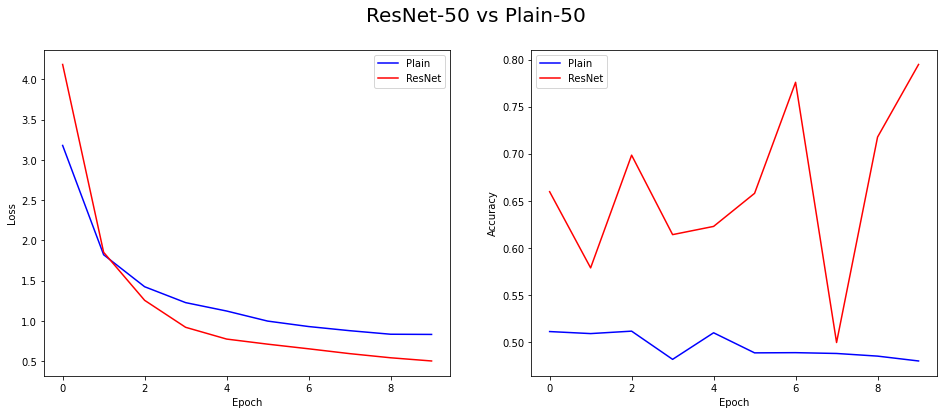

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

plt.suptitle('ResNet-50 vs Plain-50',size=20)


plt.subplot(1,2,1)
plt.plot(history_plain_50.history['loss'],'b')
plt.plot(history_resnet_50.history['loss'],'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Plain','ResNet'])

plt.subplot(1,2,2)
plt.plot(history_plain_50.history['val_accuracy'],'b')
plt.plot(history_resnet_50.history['val_accuracy'],'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Plain','ResNet'])

plt.show()

* ResNet-50 압승

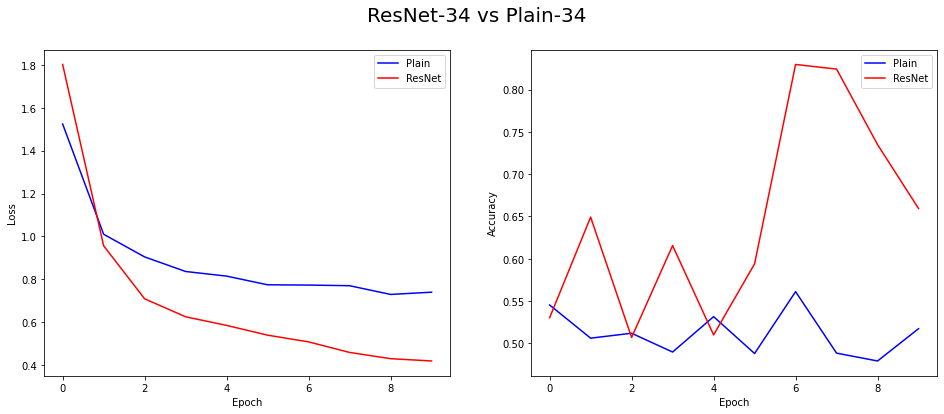

In [35]:
plt.figure(figsize=(16,6))

plt.suptitle('ResNet-34 vs Plain-34',size=20)

plt.subplot(1,2,1)
plt.plot(history_plain_34.history['loss'],'b')
plt.plot(history_resnet_34.history['loss'],'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Plain','ResNet'])

plt.subplot(1,2,2)
plt.plot(history_plain_34.history['val_accuracy'],'b')
plt.plot(history_resnet_34.history['val_accuracy'],'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Plain','ResNet'])

plt.show()

* ResNet-34 압승

# 회고

레이어를 깊게 쌓을수록 성능이 떨어지는 것을 해결하기위해 resnet을 고안하였다. shortcut을 만들어주어 gradient vanishing 문제를 해결하여 레이어를 깊게 쌓아 성능도 올릴 수 있다. 이번 프로젝트를 통하여 ResNet을 구현을 해보고 시각화를 통해 압도적으로 성능이 올라감을 확인할 수 있었다. 